# Aim 
* Understanding the forward pass
* Manually calculating gradients
* Implementing automated backpropagation
* Visualizing the computation graph

In [72]:
# A Value object represents a variable in a computation and tracks two key pieces of information:
# 1. The current value of the variable
# 2. How this variable affects the final output (its gradient)

from graphviz import Digraph

from graphviz import Digraph

import numpy as np

class Value:
    def __init__(self, data, label="", prev=[], op=""):
        self.data = data
        self.grad = 0
        self.label = label
        self.prev = prev
        self._backwards = lambda: None
        self.op = op

    def backwards(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backwards()

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, prev=[self, other], op="+")

        def backwards():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backwards = backwards
        return out
    
    def pow(self, other):
        assert isinstance(other, (int, float)), "Exponent must be a scalar"
        out = Value(self.data ** other, prev=[self], op=f"**{other}")
        def backwards():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backwards = backwards
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * other.pow(-1)

    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, prev=[self, other], op="*")
        def backwards():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backwards = backwards
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        tanh_value = (np.exp(self.data) - np.exp(-1 * self.data)) / (np.exp(self.data) + np.exp(-1 * self.data))
        out = Value(tanh_value , prev=[self], op="tanh")
        def backwards():
            self.grad += (1 - tanh_value ** 2) * out.grad
        out._backwards = backwards
        return out
    
    def exp(self):
        out = Value(np.exp(self.data), prev=[self], op="exp")
        def backwards():
            self.grad += np.exp(self.data) * out.grad
        out._backwards = backwards
        return out
        
    def __repr__(self):
        return f"Value(label={self.label}, data={self.data}, grad={self.grad})"
    
    def _build(self):
        """builds a set of all nodes and edges in a graph"""
        nodes, edges = set(), set()
        
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v.prev:
                    edges.add((child, v))
                    build(child)
        build(self)
        return nodes, edges
    
    def draw_dot(self):
        """Creates a visualization of the computation graph"""
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        
        nodes, edges = self._build()
        
        # Add all nodes to graph
        for n in nodes:
            uid = str(id(n))
            # Create a node label with data and optional label
            node_label = f"data {n.data:.4f}"
            if n.label:
                node_label += f" | label {n.label}"
                
            if n.grad:
                node_label += f" | grad {n.grad}"
            
            # Add the node as a box
            dot.node(name=uid, 
                    label=node_label,
                    shape='record')
            
            # If it's an operation result, add the operation node
            if n.op:
                op_id = uid + n.op
                dot.node(name=op_id, label=n.op, shape='circle')
                dot.edge(op_id, uid)
        
        # Add edges between nodes
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2.op)
        
        return dot

# Manual backpropagation 
A neuron can be expressed as 

$o = \tanh(x_1w_1 + x_2w_2 + b)$

We will back propagate the nueron at x1 = 2, x2 = 0, w1= -3, w2 =1, b = 6.8814 

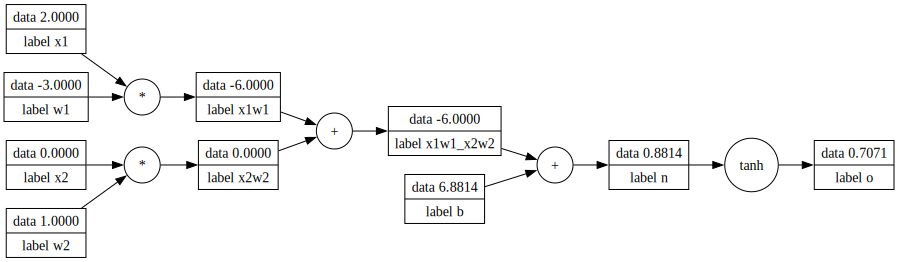

In [43]:
#  x1 = 2, x2 = 0, w1= -3, w2 =1, b = 6.8814 
x1 = Value(2.0, label="x1")
x2 = Value(0, label="x2")
b = Value(6.8814, label="b")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2 ; x1w1_x2w2.label = "x1w1_x2w2"
n = x1w1_x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.draw_dot()

# Output Gradient ∂o/∂o
By defination ∂o/∂o = 1

# ∂o/∂n
```
o = tanh(n)
∂o/∂n = 1 - tanh²(n) = 1 - 0.7071² = 0.5
```
# ∂o/∂x1w1_x2w2 and ∂o/∂b
```
n = x1w1_x2w2 + b
∂o/∂(x1w1_x2w2) = ∂o/∂n * ∂n/∂(x1w1_x2w2)
                 = 0.5 * 1 = 0.5    [since ∂n/∂(x1w1_x2w2) = 1 for addition]

∂o/∂b = ∂o/∂n * ∂n/∂b
      = 0.5 * 1 = 0.5      [since ∂n/∂b = 1 for addition]
```
# ∂o/∂x1w1 and ∂o/∂x2w2
```
x1w1_x2w2 = x1w1 + x2w2

∂o/∂(x1w1) = ∂o/∂(x1w1_x2w2) * ∂(x1w1_x2w2)/∂(x1w1)
           = 0.5 * 1 = 0.5    [since ∂(x1w1_x2w2)/∂(x1w1) = 1 for addition]

∂o/∂(x2w2) = ∂o/∂(x1w1_x2w2) * ∂(x1w1_x2w2)/∂(x2w2)
           = 0.5 * 1 = 0.5    [since ∂(x1w1_x2w2)/∂(x2w2) = 1 for addition]
```

# ∂o/∂w1, ∂o/∂x1
```
∂o/∂w1 = ∂o/∂(x1w1) * ∂(x1w1)/∂w1
       = 0.5 * x1                [since ∂(x1w1)/∂w1 = x1]
       = 0.5 * 2 = 1            [given x1 = 2]

∂o/∂x1 = ∂o/∂(x1w1) * ∂(x1w1)/∂x1
       = 0.5 * w1               [since ∂(x1w1)/∂x1 = w1]
       = 0.5 * -3 = -1.5       [given w1 = -3]
```
# ∂o/∂w2, ∂o/∂x2
```
x2w2 = x2 * w2

∂o/∂w2 = ∂o/∂(x2w2) * ∂(x2w2)/∂w2
       = 0.5 * x2                [since ∂(x2w2)/∂w2 = x2]
       = 0.5 * 0 = 0            [given x2 = 0]

∂o/∂x2 = ∂o/∂(x2w2) * ∂(x2w2)/∂x2
       = 0.5 * w2               [since ∂(x2w2)/∂x2 = w2]
       = 0.5 * 1 = 0.5         [given w2 = 1]
```



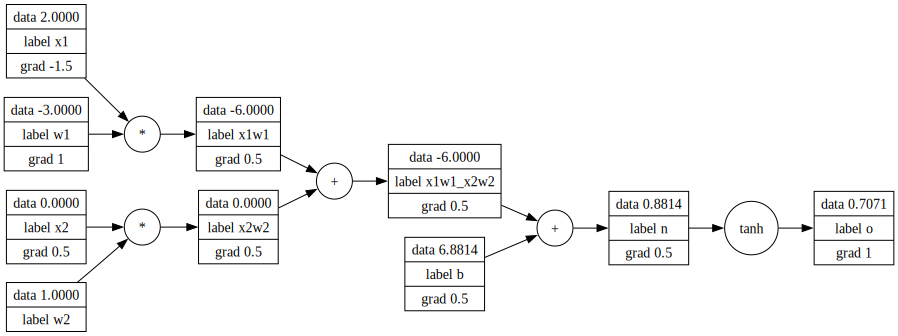

In [46]:
x2.grad = 0.5; w2.grad = 0; w1.grad = 1; x1.grad = -1.5; x1w1.grad = 0.5; x2w2.grad = 0.5; x1w1_x2w2.grad = 0.5; b.grad = 0.5; n.grad = 0.5; o.grad = 1 
o.draw_dot()

# Automated backpropagation 

We can recursively backpropgate from ```o``` to derive gradient of above equation tree. 

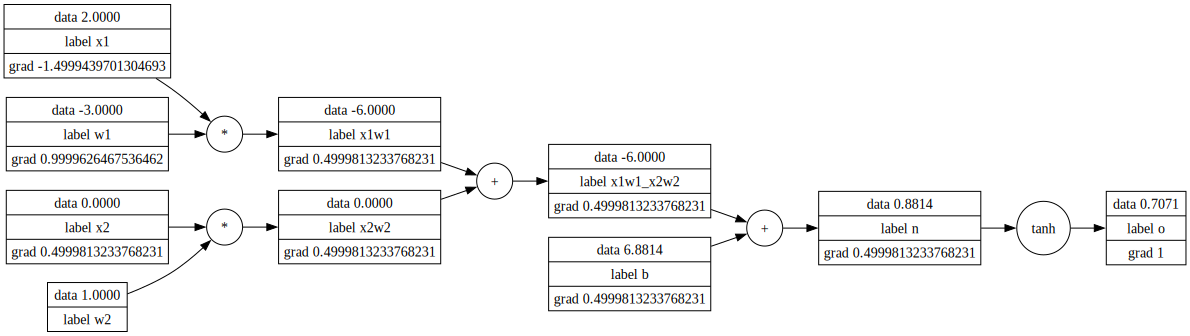

In [ ]:
o.backwards()
o.draw_dot()

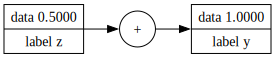

In [68]:
z = Value(0.5, label="z")
y = z + z; y.label = "y"
y.draw_dot()


In [52]:
y.backwards()

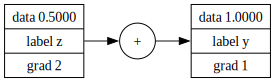

In [53]:
y.draw_dot()

In [69]:
1 * z

Value(label=, data=0.5, grad=0)

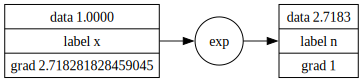

In [74]:
x = Value(1, label="x")
n = x.exp(); n.label = "n"
n.backwards()
n.draw_dot()